In [53]:
from keras import layers
from keras import models
from keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [54]:
def plot_history(hst):
    plt.figure(figsize=(13, 4))

    plt.subplot(1, 2, 1)
    plt.plot(hst.history['loss'], label='train')
    plt.plot(hst.history['val_loss'], label='test')
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot([round(100*e, 2) for e in hst.history['accuracy']], label='train')
    plt.plot([round(100*e, 2) for e in hst.history['val_accuracy']], label='test')
    plt.title('Accuracy')    

    plt.ylim(0, 100)
    plt.legend()
    plt.tight_layout()
    plt.show()

Частина 1. Побудова архітектури згорткової нейронної мережі

In [55]:

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation="relu"),

    layers.Flatten(),
    layers.Dense(64, activation="relu"),

    layers.Dense(10, activation="softmax")
])


/Users/anastsiasmirnova/.local/share/virtualenvs/goit-ds-hw-12-_31BA9zN/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [56]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,322 (364.54 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

In [57]:

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [58]:
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype("float32") / 255
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [59]:

model.compile(
    optimizer="rmsprop",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)




In [ ]:
history  =  model.fit(train_images, train_labels, validation_data=(test_images, test_labels), epochs=5, batch_size=64)

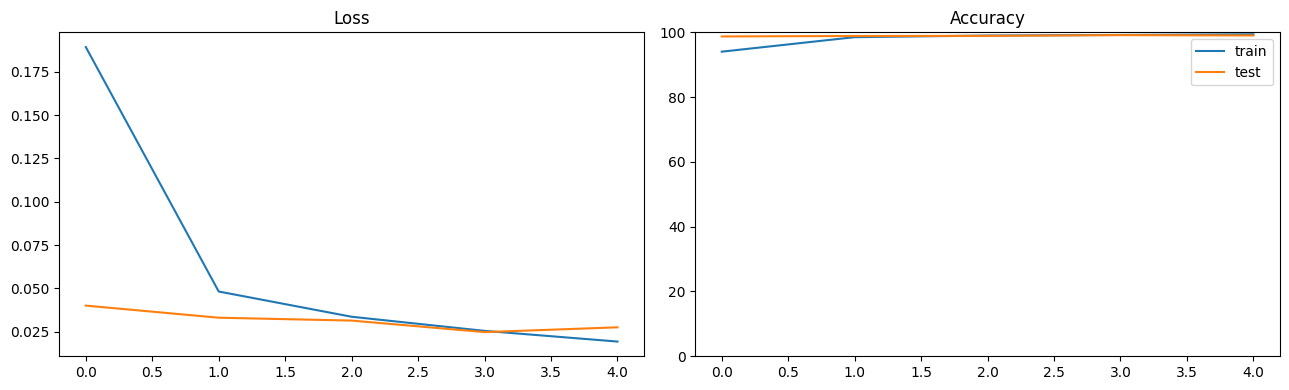

In [23]:
plot_history(history)

Частина 2. Використання передвиборних мереж. Виділення ознак

In [60]:
import cv2

train_images_3D = np.zeros((60000, 32, 32, 3), dtype=train_images.dtype)
test_images_3D = np.zeros((10000, 32, 32, 3), dtype=train_images.dtype)

for i in range(train_images.shape[0]):
    # Resize the single image (28, 28, 1) to (224, 224, 3)
    resized_TR_image = cv2.resize(train_images[i, :, :, 0], (32, 32), interpolation=cv2.INTER_LINEAR)
    train_images_3D[i] = np.repeat(resized_TR_image[:, :, np.newaxis], 3, axis=2)
    if i < 10000:
        resized_T_image = cv2.resize(test_images[i, :, :, 0], (32, 32), interpolation=cv2.INTER_LINEAR)
        train_images_3D[i] = np.repeat(resized_T_image[:, :, np.newaxis], 3, axis=2)
    




In [64]:


train_datagen =  tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_generator = train_datagen.flow(train_images_3D, train_labels, batch_size=1000)

validation_generator = test_datagen.flow(test_images_3D, test_labels, batch_size=1000)

In [65]:
from keras.applications.vgg16 import VGG16

conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(32,32,3))

conv_base.trainable = False

model = models.Sequential([
   conv_base,
   layers.Flatten(),
   layers.Dense(256, activation="relu"),
   layers.Dense(10, activation="softmax"),
])

model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5),
    metrics=["acc"]
)

model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,586 (56.64 MB)

 Trainable params: 133,898 (523.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [66]:
history = model.fit(
    train_generator,
    steps_per_epoch=20,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=50
)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - acc: 0.1075 - loss: 2.4047 - val_acc: 0.1000 - val_loss: 2.4378
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - acc: 0.1109 - loss: 2.3442 - val_acc: 0.1000 - val_loss: 2.4131
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 79s 4s/step - acc: 0.1335 - loss: 2.2995 - val_acc: 0.1000 - val_loss: 2.3955
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - acc: 0.1508 - loss: 2.2569 - val_acc: 0.1000 - val_loss: 2.3810
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - acc: 0.1747 - loss: 2.2250 - val_acc: 0.1000 - val_loss: 2.3718
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 86s 4s/step - acc: 0.2005 - loss: 2.1893 - val_acc: 0.1000 - val_loss: 2.3661
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - acc: 0.2353 - loss: 2.1585 - val_acc: 0.1000 - val_loss: 2.3633
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 89s 5s/step - acc: 0.2846 - loss: 2.1297 - val_acc: 0.1000 - val_loss: 2.3625
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 91s 5s/step - acc: 0.3184 - loss: 

KeyboardInterrupt: 

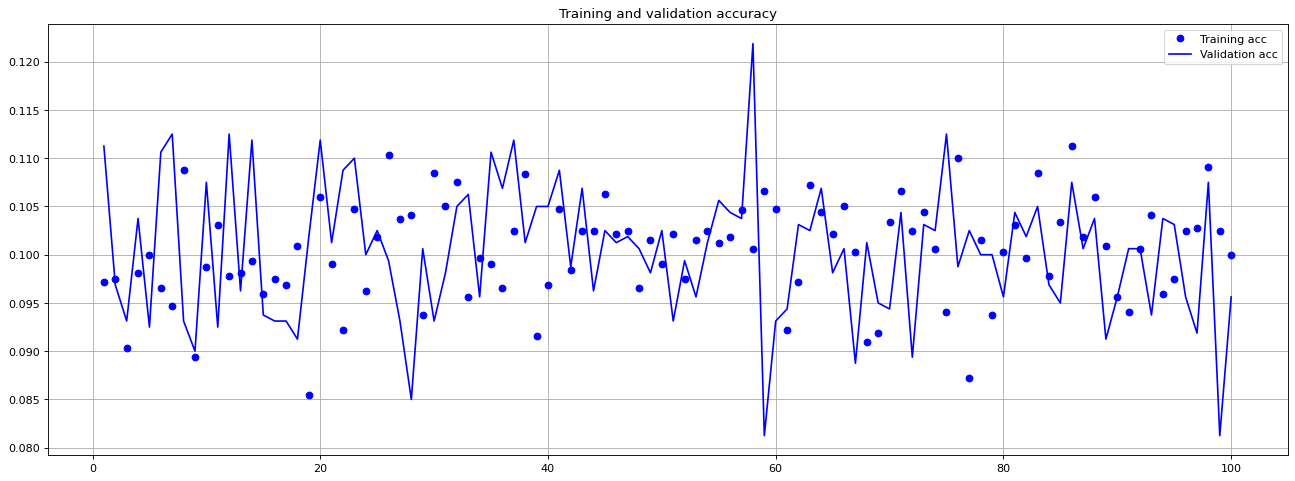

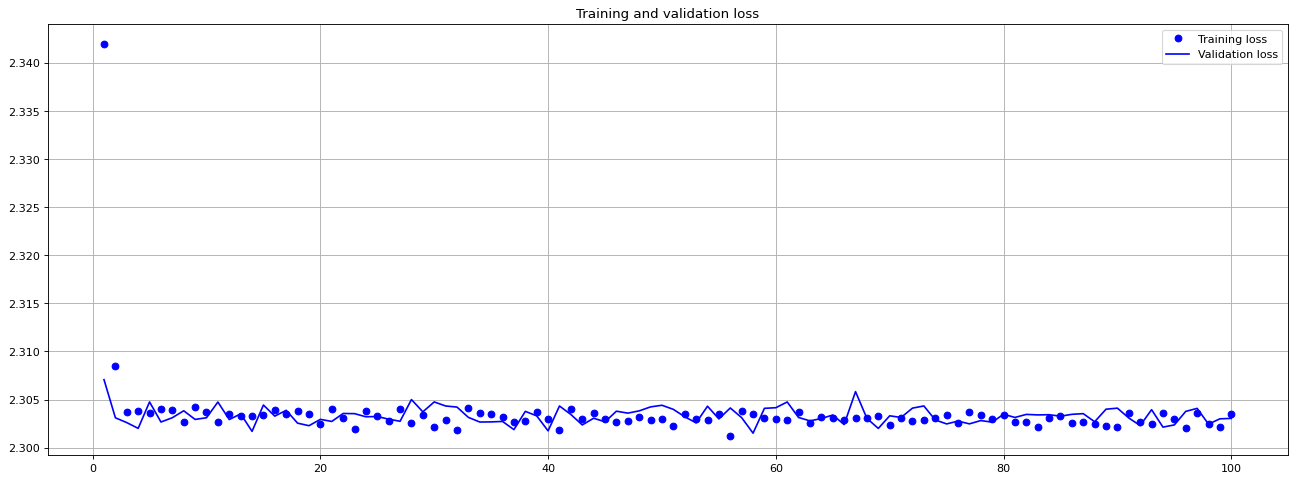

In [34]:
import matplotlib.pyplot as plt

acc = history.history["acc"]
val_acc = history.history["val_acc"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(20, 7), dpi=80)
plt.grid(True)

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")

plt.title("Training and validation accuracy")
plt.legend()

plt.figure(figsize=(20, 7), dpi=80)
plt.grid(True)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss") 
plt.title("Training and validation loss")

plt.legend()
plt.show()


Частина 2. Використання передвиборних мереж. Донавчання

In [39]:
conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(32,32,3))

In [40]:
set_trainable = False
for layer in conv_base.layers:
    if layer.name == "block5_conv1":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [43]:
model = models.Sequential([
   conv_base,
   layers.Flatten(),
   layers.Dense(256, activation="relu"),
   layers.Dense(10, activation="softmax"),
])

model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5),
    metrics=["acc"]
)

model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,586 (56.64 MB)

 Trainable params: 7,213,322 (27.52 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [44]:
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50
)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 176ms/step - acc: 0.0850 - loss: 2.3567 - val_acc: 0.0988 - val_loss: 2.3078
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 191ms/step - acc: 0.1038 - loss: 2.3077 - val_acc: 0.0969 - val_loss: 2.3047
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 211ms/step - acc: 0.0930 - loss: 2.3068 - val_acc: 0.1075 - val_loss: 2.3042
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 208ms/step - acc: 0.0964 - loss: 2.3076 - val_acc: 0.1125 - val_loss: 2.3038
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 204ms/step - acc: 0.0961 - loss: 2.3061 - val_acc: 0.1050 - val_loss: 2.3071
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 219ms/step - acc: 0.0995 - loss: 2.3056 - val_acc: 0.1106 - val_loss: 2.3042
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 245ms/step - acc: 0.0901 - loss: 2.3099 - val_acc: 0.1056 - val_loss: 2.3066
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 219ms/step - acc: 0.0838 - loss: 2.3091 - val_acc: 0.0962 - val_loss: 2.3164
Epoch 9/100
100/100 ━━━━

In [46]:
train_images_3D.shape

(60000, 32, 32, 3)

array([0.37162992, 0.37162992, 0.37162992], dtype=float32)